In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
import muon as mu

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.13


In [4]:
mdata = mu.read("/Users/jerryaaaaaa/clonal_label.h5mu")

/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


Drop cells with NA clonal_dynamic labeling

In [5]:
valid_cells = mdata["airr"].obs[~mdata["airr"].obs["clonal_dynamic_label"].isna()].index
mdata_filtered = mdata[valid_cells].copy()
mdata_filtered["gex"].obs["clonal_dynamic_label"] = mdata_filtered["airr"].obs["clonal_dynamic_label"]
mdata_filtered["gex"].obs["clonal_dynamic"] = mdata_filtered["airr"].obs["clonal_dynamic"]
mdata_filtered["gex"].obs["clone_id"] = mdata_filtered["airr"].obs["clone_id"]

Add TCR info to ["airr"].obs

In [6]:
cdr3_info = ir.get.airr(
    mdata_filtered["airr"],
    airr_variable=["cdr3_aa"],
    chain=["VJ_1", "VDJ_1"]
)
mdata_filtered["airr"].obs["alpha_cdr3_aa"] = cdr3_info["VJ_1_cdr3_aa"]
mdata_filtered["airr"].obs["beta_cdr3_aa"] = cdr3_info["VDJ_1_cdr3_aa"]

Extract cell IDs and labels for train_test split

Stratify = labels(targets) ensures the proportion of each class is preserved in both train and test sets

In [7]:
cell_ids = mdata_filtered.obs_names
targets = mdata_filtered["airr"].obs["clonal_dynamic_label"]

train_cells, test_cells = train_test_split(
    cell_ids,
    test_size=0.2,
    stratify=targets,
    random_state=42
)

mdata_train = mdata_filtered[train_cells].copy()
mdata_test = mdata_filtered[test_cells].copy()

Differential expression gene (DEGs)

In [8]:
sc.tl.rank_genes_groups(mdata_train["gex"], groupby="clonal_dynamic", method="wilcoxon")

ranking genes


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [9]:
deg_df = sc.get.rank_genes_groups_df(mdata_train["gex"], group="Enriched", pval_cutoff=0.05)
deg_genes = deg_df["names"].unique().tolist()

In [10]:
#Canonical tumor-reactive gene list
markers = ["HAVCR2", "ITGAE", "TOX", "ENTPD1", "CD69", 
           "IFNG", "GZMB", "PRF1", "LAMP1",
           "IL7R", "TCF7", "TIGIT", "EOMES"
           ]

In [11]:
feature_genes = list(set(deg_genes + markers))

Extract gene expression as dataframe

In [12]:
gex_train = mdata_train["gex"].to_df()
gex_test = mdata_test["gex"].to_df()

Extract TCR info as dataframe (computing cdr3 length)

In [14]:
tcr_train = mdata_train["airr"].obs[["alpha_cdr3_aa", "beta_cdr3_aa"]].copy()
tcr_test = mdata_test["airr"].obs[["alpha_cdr3_aa", "beta_cdr3_aa"]].copy()

tcr_train["alpha_cdr3_len"] = tcr_train["alpha_cdr3_aa"].apply(lambda x: len(x) if isinstance(x, str) else 0)
tcr_train["beta_cdr3_len"] = tcr_train["beta_cdr3_aa"].apply(lambda x: len(x) if isinstance(x, str) else 0)

tcr_test["alpha_cdr3_len"] = tcr_test["alpha_cdr3_aa"].apply(lambda x: len(x) if isinstance(x, str) else 0)
tcr_test["beta_cdr3_len"] = tcr_test["beta_cdr3_aa"].apply(lambda x: len(x) if isinstance(x, str) else 0)


In [15]:
gex_train = gex_train.loc[:, gex_train.columns.intersection(feature_genes)]
gex_test = gex_test.loc[:, gex_test.columns.intersection(feature_genes)]

In [23]:
tcr_feature_train = tcr_train[["alpha_cdr3_len", "beta_cdr3_len"]]
tcr_feature_test = tcr_test[["alpha_cdr3_len", "beta_cdr3_len"]]

In [24]:
X_train = pd.concat([gex_train, tcr_feature_train], axis=1)
X_test = pd.concat([gex_test, tcr_feature_test], axis=1)

In [18]:
y_train = mdata_train["gex"].obs["clonal_dynamic_label"].copy()
y_test = mdata_test["gex"].obs["clonal_dynamic_label"].copy()

Model Training

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

Considering class imbalance

In [20]:
#Compute class ratio
ratio = (y_train == 0).sum() / (y_train == 1).sum()

In [28]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=ratio,
    eval_metric="logloss",
    random_state=42
)

In [29]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [30]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

In [31]:
print("ROC_AUC:", roc_auc_score(y_test, y_proba))

ROC_AUC: 0.9960743801652892


Model performance evaluation/ROC_AUC

In [35]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

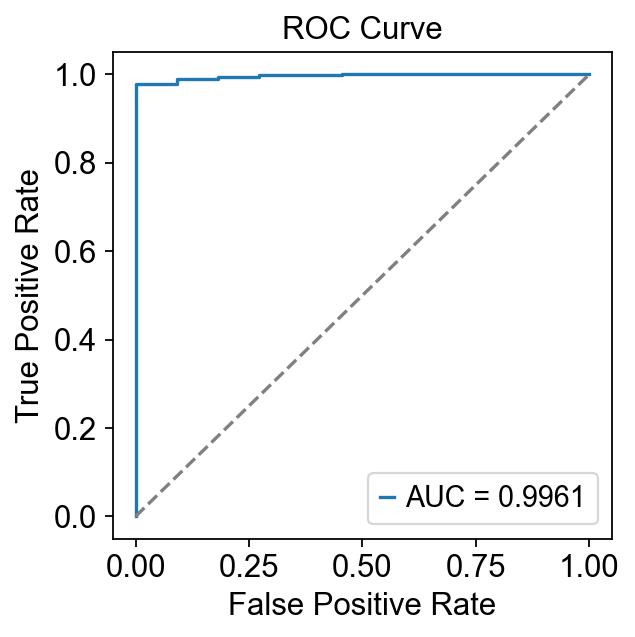

In [75]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

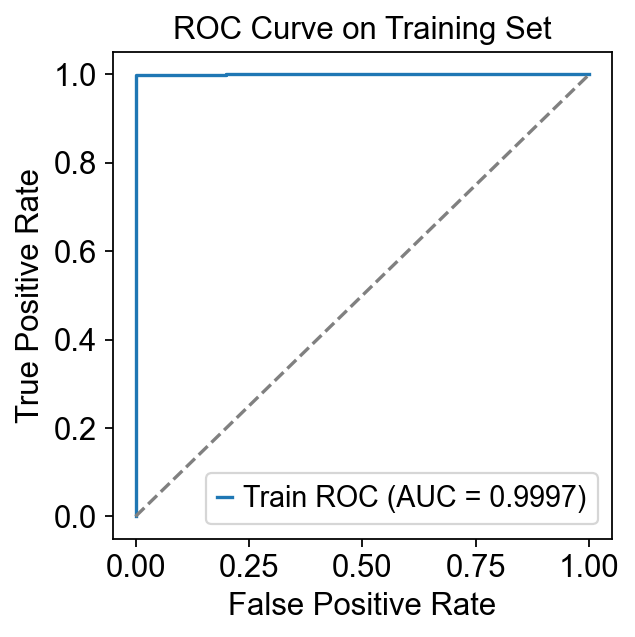

In [84]:
y_train_proba = xgb_model.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_proba)

fpr, tpr, _ = roc_curve(y_train, y_train_proba)

plt.plot(fpr, tpr, label=f"Train ROC (AUC = {train_auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Training Set")
plt.legend()
plt.grid(False)
plt.show()

Model performance evaluation/Precision and Recall

In [85]:
print(classification_report(y_test, y_pred, target_names=["Eclipsed", "Enriched"]))

              precision    recall  f1-score   support

    Eclipsed       0.50      0.91      0.65        11
    Enriched       1.00      0.99      0.99       880

    accuracy                           0.99       891
   macro avg       0.75      0.95      0.82       891
weighted avg       0.99      0.99      0.99       891



In [86]:
from sklearn.metrics import precision_recall_curve, average_precision_score

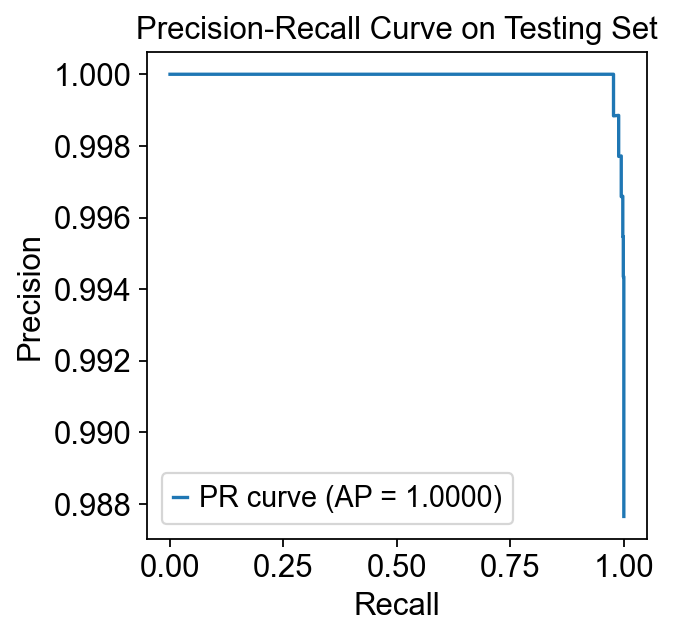

In [91]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.plot(recall, precision, label=f"PR curve (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve on Testing Set")
plt.legend()
plt.grid(False)
plt.show()

Cross Validation

In [37]:
from sklearn.model_selection import cross_val_score

In [38]:
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring="roc_auc")
print("Cross-validated AUCs:", scores)
print("Mean AUC:", np.mean(scores))

Cross-validated AUCs: [0.99842172 0.99605429 0.99794531 0.99778726 0.99525842]
Mean AUC: 0.9970934002184002


Visualizing feature importance/Get feature importance dataframe

In [39]:
from xgboost import plot_importance

In [53]:
importance_dict = xgb_model.get_booster().get_score(importance_type="weight")

importance_df = pd.DataFrame({
    "feature": list(importance_dict.keys()),
    "importance": list(importance_dict.values())
})
importance_df = importance_df.sort_values(by="importance", ascending=False)

In [54]:
importance_df

,feature,importance
30,beta_cdr3_len,52.0
29,alpha_cdr3_len,41.0
5,ITM2C,20.0
7,TNFSF10,16.0
6,EOMES,14.0
25,NCF4,11.0
21,PECAM1,9.0
26,ITM2A,9.0
0,TNFRSF9,8.0
3,CAPG,8.0


In [100]:
import seaborn as sns

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_33810/3494950050.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y="feature", x="importance", palette="magma")


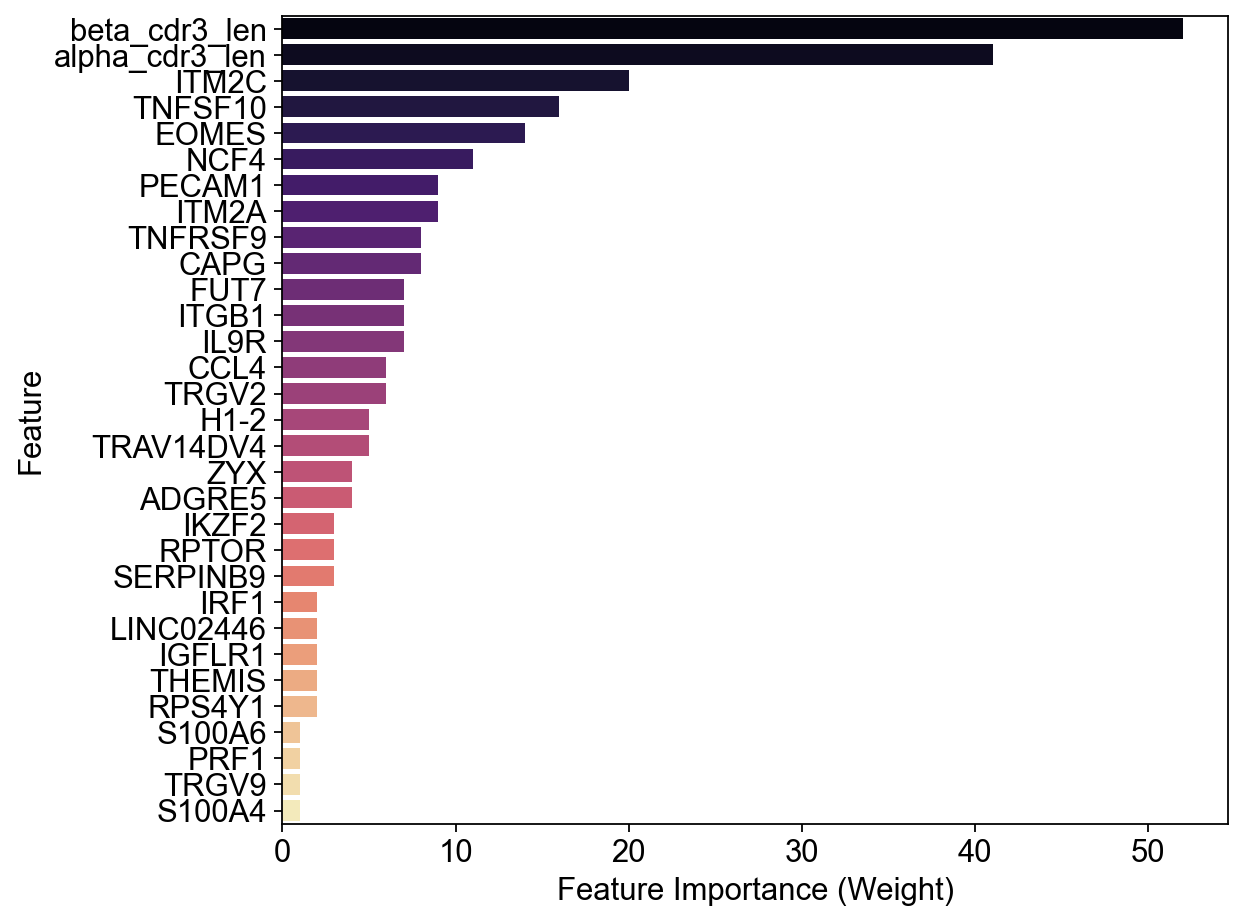

In [102]:
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, y="feature", x="importance", palette="magma")

plt.xlabel("Feature Importance (Weight)")
plt.ylabel("Feature")
plt.grid(False)
plt.tight_layout()
plt.show()

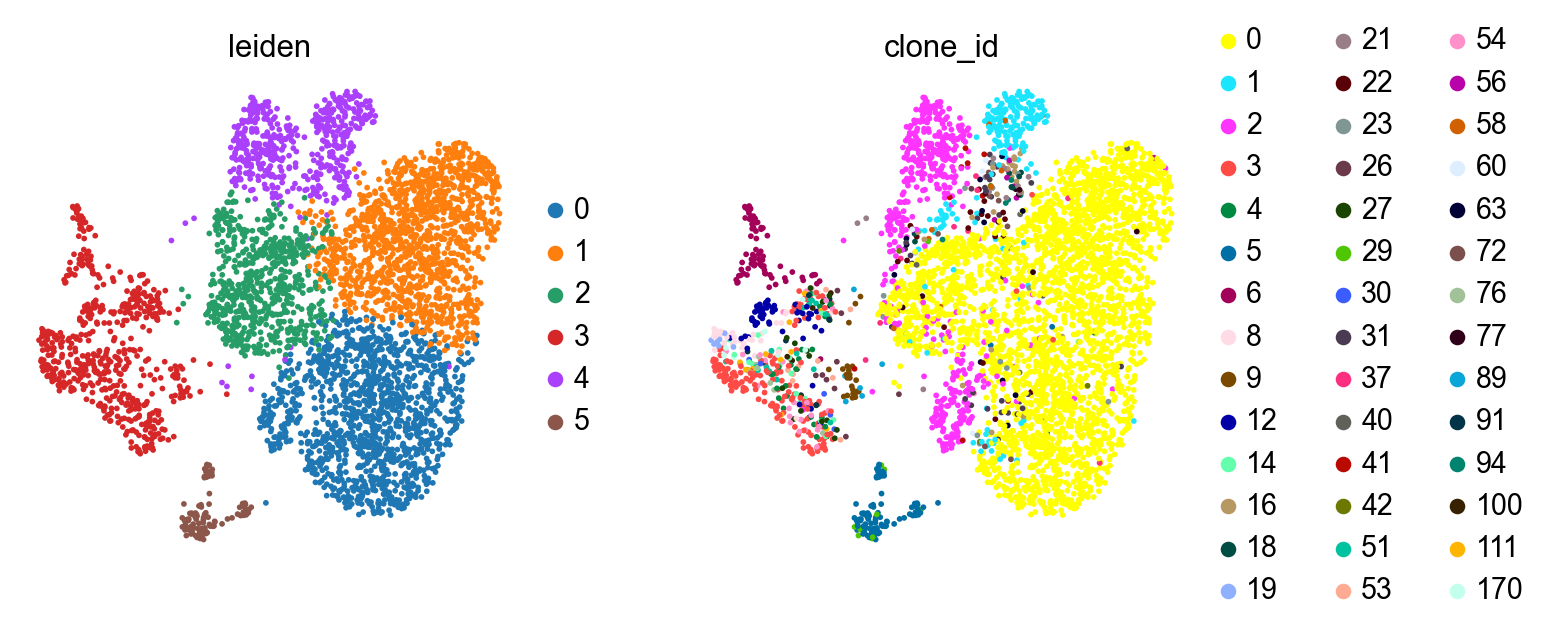

In [64]:
sc.pl.umap(mdata_filtered["gex"], color=["leiden", "clone_id"], frameon=False)

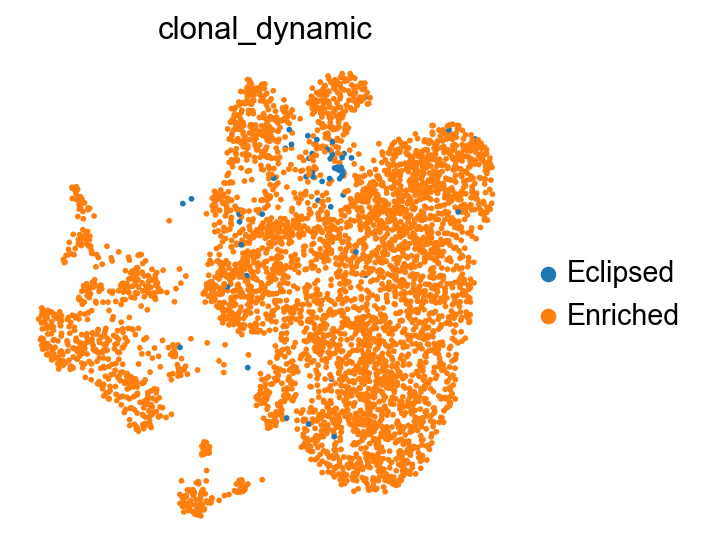

In [63]:
sc.pl.umap(mdata_filtered["gex"], color="clonal_dynamic", frameon=False)

Visualizing DEGs

In [65]:
degs = sc.get.rank_genes_groups_df(mdata_train["gex"], group="Enriched")

In [66]:
import seaborn as sns

In [68]:
degs["pvals_adj"] = pd.to_numeric(degs["pvals_adj"], errors="coerce")

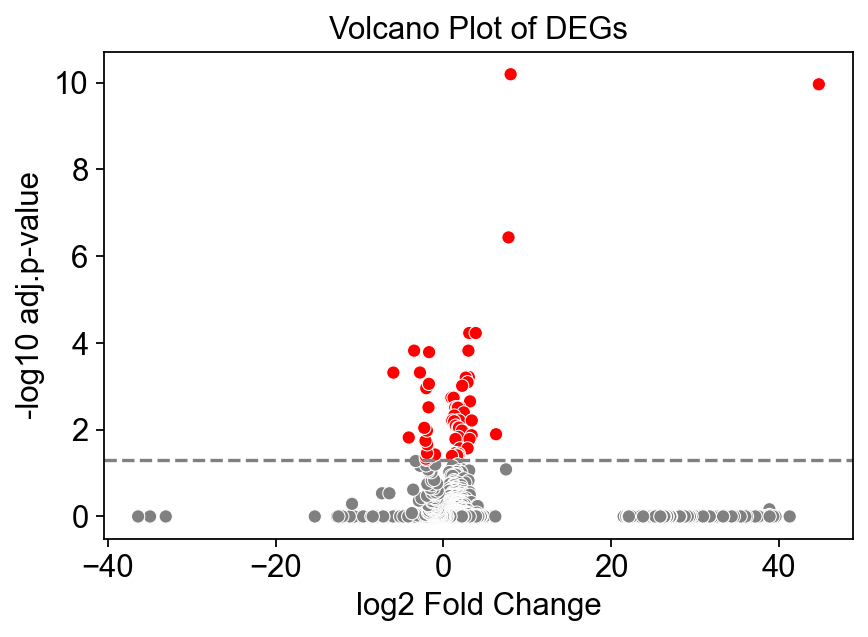

In [82]:
min_pval = 1e-300
degs["pvals_adj_capped"] = degs["pvals_adj"].clip(lower=min_pval)
degs["minus_log10_pval"] = -np.log10(degs["pvals_adj_capped"])
degs["log2FC"] = degs["logfoldchanges"] / np.log(2)

plt.figure(figsize=(6, 4))
sns.scatterplot(data=degs,
                x="log2FC", y="minus_log10_pval", hue=degs["pvals_adj"] < 0.05,
                palette={True: "red", False: "grey"}, legend=False
                )
plt.axhline(-np.log10(0.05), color="grey", linestyle="--")

plt.xlabel("log2 Fold Change")
plt.ylabel("-log10 adj.p-value")
plt.title("Volcano Plot of DEGs")
plt.grid(False)
plt.show()

In [92]:
degs.to_csv("/Users/jerryaaaaaa/clonal_degs_all.csv")

In [97]:
degs_pval_cutoff = degs[degs["pvals_adj"] < 0.05].copy()
degs_pval_cutoff.to_csv("/Users/jerryaaaaaa/clonal_degs_pval_0.05.csv")

In [99]:
degs_pval_cutoff_2 = degs[degs["minus_log10_pval"] > 0].copy()
degs_pval_cutoff_2.to_csv("/Users/jerryaaaaaa/clonal_degs_cutoff.csv")

Top feature (CDR3β length (aa))/Distribution across clonal dynamics

In [104]:
mdata_filtered["airr"].obs["alpha_cdr3_len"] = mdata_filtered["airr"].obs["alpha_cdr3_aa"].apply(lambda x: len(x) if isinstance(x, str) else 0)
mdata_filtered["airr"].obs["beta_cdr3_len"] = mdata_filtered["airr"].obs["beta_cdr3_aa"].apply(lambda x: len(x) if isinstance(x, str) else 0)

In [105]:
df = mdata_filtered["airr"].obs[["clonal_dynamic", "alpha_cdr3_len", "beta_cdr3_len"]]

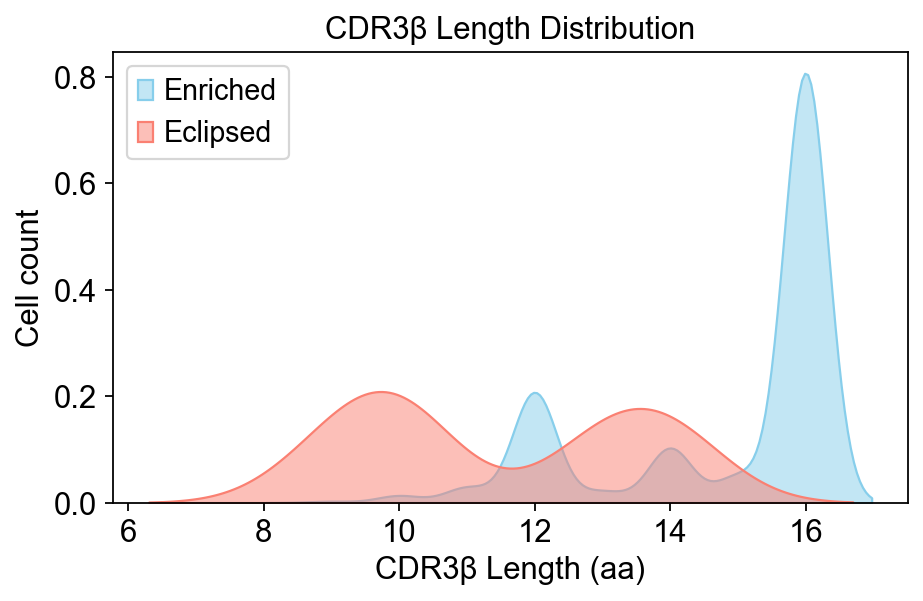

In [117]:
beta_enriched = df[df["clonal_dynamic"] == "Enriched"]["beta_cdr3_len"]
beta_eclipsed = df[df["clonal_dynamic"] == "Eclipsed"]["beta_cdr3_len"]

plt.figure(figsize=(6, 4))

sns.kdeplot(beta_enriched, fill=True, alpha=0.5, label="Enriched", color="skyblue")
sns.kdeplot(beta_eclipsed, fill=True, alpha=0.5, label="Eclipsed", color="salmon")

plt.xlabel("CDR3β Length (aa)")
plt.ylabel("Cell count")
plt.legend()
plt.title("CDR3β Length Distribution")
plt.grid(False)
plt.tight_layout()
plt.show()

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_33810/2339369122.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


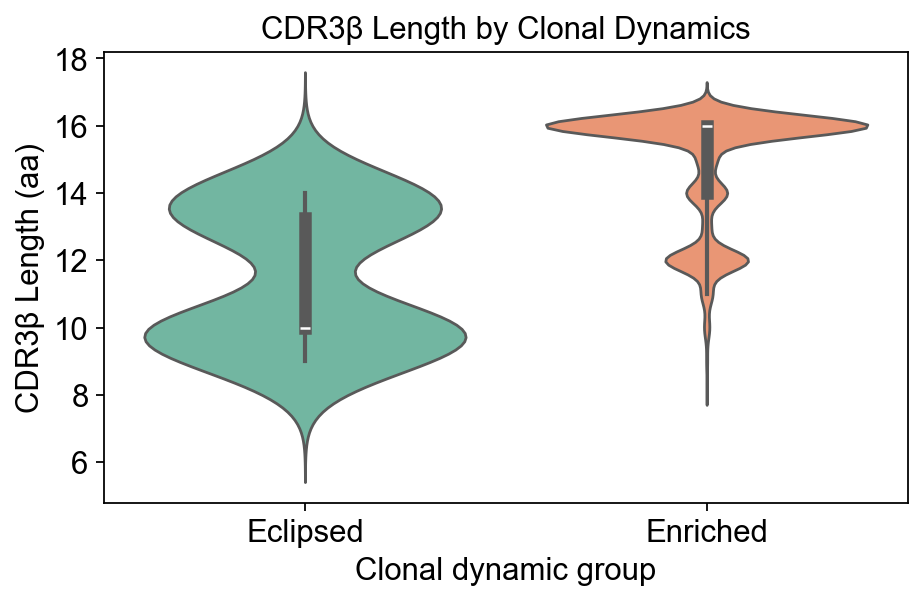

In [113]:
plt.figure(figsize=(6, 4))
sns.violinplot(
    data=df,
    x="clonal_dynamic",
    y="beta_cdr3_len",
    palette="Set2",
    inner="box",
    cut=4
)
plt.title("CDR3β Length by Clonal Dynamics")
plt.ylabel("CDR3β Length (aa)")
plt.xlabel("Clonal dynamic group")
plt.tight_layout()
plt.grid(False)
plt.show()